In [142]:
%matplotlib inline
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

In [143]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()
    

training_dir = "HackathonIII/Expression_data/Facial_expression_train/"
testing_dir = "HackathonIII/Expression_data/Facial_expression_test/"
train_batch_size = 100
test_batch_size = 10
train_number_epochs = 100

In [144]:
train_data = torchvision.datasets.ImageFolder(training_dir, transform=transforms.Compose([transforms.Resize((128,128)),
                                                                      transforms.ToTensor(),
                                                                      ]))
classes = train_data.classes

test_data = torchvision.datasets.ImageFolder(testing_dir, transform=transforms.Compose([transforms.Resize((128,128)),
                                                                      transforms.ToTensor()
                                                                      ]))


In [145]:
from torchvision import transforms


train_loader = torch.utils.data.DataLoader(train_data,
                                          batch_size=train_batch_size,
                                          shuffle=True,
                                          num_workers=1)

test_loader = torch.utils.data.DataLoader(test_data,
                                          batch_size=test_batch_size,
                                          shuffle=False,
                                          num_workers=1)

Mini batch size: images - torch.Size([100, 3, 128, 128])  labels -  torch.Size([100])
torch.Size([3, 128, 128]) tensor(1)


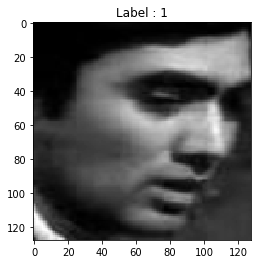

torch.Size([3, 128, 128]) tensor(3)


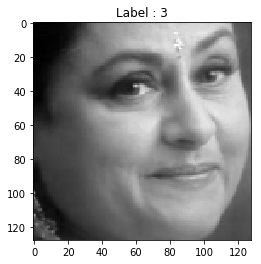

Mini batch size: images - torch.Size([100, 3, 128, 128])  labels -  torch.Size([100])
torch.Size([3, 128, 128]) tensor(5)


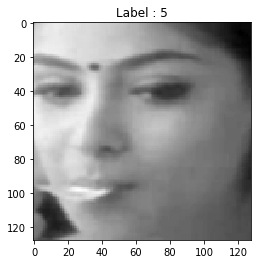

torch.Size([3, 128, 128]) tensor(4)


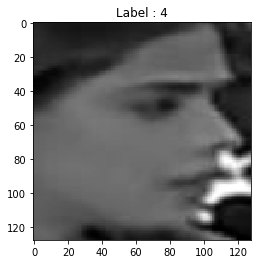

In [146]:
count = 0
for mini_batch in train_loader:
    images, labels = mini_batch
    print('Mini batch size: images -', images.size(), ' labels - ', labels.size())
    for j in range(train_batch_size):
        print(images[j].size(), labels[j])
        plt.imshow(images[j][0].numpy(), cmap='gray')
        plt.title('Label : %i' % labels[j])
        plt.show()

# Some logic to break the loops so that we dont print the whole dataset.
        if j == 1:
            break
    if count == 1:
        break
        
    count +=1

In [147]:
# A CNN based Feature extractor
# Definining neural network in python by a class which inherits from nn.Module
class LeNet(nn.Module):
    """LeNet feature extractor model."""

    def __init__(self):
        """Init LeNet feature extractor model."""
        super(LeNet, self).__init__()

        # Defining the CNNfeature Extractor
        self.feature_extractor = nn.Sequential(
            # input [1 x 128 x 128]
            # 1st conv layer
            # Conv which convolves input image with 6 filters of 5x5 size, without padding

            nn.Conv2d(3, 6, kernel_size=5),
            # [6 x 124 x 124]
            nn.MaxPool2d(kernel_size=2), # Max pooling subsampling operation
            # [6 x 64 x 64]
            nn.ReLU(), # Non linear activation function
            # 2nd conv layer
            # input [6 x 64 x 64]
            # Conv which convolves input image with 16 filters of 5x5 size, without padding
            nn.Conv2d(6, 16, kernel_size=5),
            # [16 x 60 x 60]
            nn.MaxPool2d(kernel_size=2),
            # [16 x 30 x 30]
            nn.ReLU()
        )
        
        
        # Defining the Classifier
        self.classifier = nn.Sequential(
            # Linear layer with 120 nodes, taking a flattened [16 x 4 x 4] as input
            nn.Linear(16 * 29 * 29, 120),
            # Linear layer with 84 nodes
            nn.Linear(120, 84),
            # ReLU
            nn.ReLU(),
            # Output layer with as many nodes as number of classes
            nn.Linear(84, 7)
        )
        
    def forward(self, input):
        """Define a Forward pass of the LeNet."""
        out = self.feature_extractor(input) # Pass input through the feature extractor
#        print(out.size())
        #64, 16, 29, 29
        out = out.view(-1, 16 * 29 * 29) # Reshape the 2D to a vector
        out = self.classifier(out) # pass features through the classifier to get predictions
        return out

In [148]:
lenet = LeNet()


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

lenet = lenet.to(device)

# Print out the size of parameters of each layer
for name, param in lenet.state_dict().items():
    print(name, '\n', param.size(), '\n')

feature_extractor.0.weight 
 torch.Size([6, 3, 5, 5]) 

feature_extractor.0.bias 
 torch.Size([6]) 

feature_extractor.3.weight 
 torch.Size([16, 6, 5, 5]) 

feature_extractor.3.bias 
 torch.Size([16]) 

classifier.0.weight 
 torch.Size([120, 13456]) 

classifier.0.bias 
 torch.Size([120]) 

classifier.1.weight 
 torch.Size([84, 120]) 

classifier.1.bias 
 torch.Size([84]) 

classifier.3.weight 
 torch.Size([7, 84]) 

classifier.3.bias 
 torch.Size([7]) 



In [149]:
train_loader.batch_size

100

In [150]:
epoch = 50
loss_history = []

In [151]:
# The number of times we should iterate over the training data. 1 epoch = 1 pass over the training data
loss_func = nn.CrossEntropyLoss()

# Set the learning rate
learning_rate = 0.01

optimizer = torch.optim.Adam(lenet.parameters(), lr=learning_rate)
# optimizer = torch.optim.SGD(lenet.parameters(), lr=learning_rate, momentum=0.0)
# Train Model with train data

for i in range(epoch):
    print('####### Epoch ', i)
    for j,[image,label] in enumerate(train_loader):
        # You can try with and without using GPUs, by setting this variable before the loop
        #if use_gpu == "cuda":
        image = image.to(device)
        label = label.to(device)
            
        #image = image
        #label = label
        
        
        optimizer.zero_grad() # zero out the gradients from the preivous step 
        predictions = lenet.forward(image) # Do forward pass on the current mini batch
        
        loss = loss_func(predictions, label) # Compute loss on the current mini batch
        loss.backward() # Do backward pass. That is compute all the gradients for the current minibatch
        optimizer.step() # Update the parameters using the gradients with the learning rate
        
        if j % 100 == 0:
            print("loss so far: ", loss.item())
            loss_history.append(loss.item())
                    
        # display.clear_output(wait=True)
    print("batch completed", j)
plt.plot(loss_history)
plt.show()

####### Epoch  0
loss so far:  1.9443963766098022
loss so far:  1.8513400554656982
batch completed 109
####### Epoch  1
loss so far:  1.7746589183807373
loss so far:  1.787896752357483
batch completed 109
####### Epoch  2
loss so far:  1.8543272018432617
loss so far:  1.837788701057434
batch completed 109
####### Epoch  3
loss so far:  1.7856988906860352
loss so far:  1.742201566696167
batch completed 109
####### Epoch  4
loss so far:  1.8263344764709473
loss so far:  1.767630934715271
batch completed 109
####### Epoch  5
loss so far:  1.7807649374008179
loss so far:  1.9102787971496582
batch completed 109
####### Epoch  6
loss so far:  1.7526299953460693
loss so far:  1.7982985973358154
batch completed 109
####### Epoch  7
loss so far:  1.7525231838226318
loss so far:  1.8158453702926636
batch completed 109
####### Epoch  8
loss so far:  1.7297052145004272
loss so far:  1.7646942138671875
batch completed 109
####### Epoch  9
loss so far:  1.8181592226028442
loss so far:  1.74710130691

Process Process-118:
Traceback (most recent call last):
  File "/Users/tgupta2/anaconda3/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/Users/tgupta2/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/tgupta2/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 96, in _worker_loop
    r = index_queue.get(timeout=MANAGER_STATUS_CHECK_INTERVAL)
  File "/Users/tgupta2/anaconda3/lib/python3.6/multiprocessing/queues.py", line 104, in get
    if timeout < 0 or not self._poll(timeout):
  File "/Users/tgupta2/anaconda3/lib/python3.6/multiprocessing/connection.py", line 257, in poll
    return self._poll(timeout)
  File "/Users/tgupta2/anaconda3/lib/python3.6/multiprocessing/connection.py", line 414, in _poll
    r = wait([self], timeout)
  File "/Users/tgupta2/anaconda3/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selec

KeyboardInterrupt: 

In [152]:
correct = 0.0
total = 0.0
for mini_batch in test_loader:
    images, labels = mini_batch
    
    # You can try with and without using GPUs, by setting this variable before the loop
    #if use_gpu == "cuda":
    images = images.to(device)
    labels = labels.to(device)
        
    #images = images
    
    # Doing the Forward pass
    result = lenet(images)
    
    # Coverting the predictions to probabilities, by applying the softmax function
    result = F.softmax(result)
 
    # Finding the prediction with the largest probability
    _,pred = torch.max(result.data,1)
    
    total += labels.size(0)
    # correct is incremented by the numer of prediction which are correct (equal to the ground truth labels)
    correct += (pred == labels).sum().item()
    
print("Accuracy of Test Data: {0:.2f}%".format(correct/total *100))

/Users/tgupta2/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy of Test Data: 25.83%


In [ ]:
state = {
            'net': lenet
          
        }

torch.save(state, 'checkpoint_ckpt_48x48.t7')